<a href="https://www.einkaufspaten.de"><img src = "https://cdn.vox-cdn.com/thumbor/65ML3GNAS0M-pJzATx6bDM5xDII=/110x0:1884x1331/1820x1213/filters:focal(110x0:1884x1331)/cdn.vox-cdn.com/uploads/chorus_image/image/49940367/2015-09-11-maia-007.0.0.jpg" align=center width = 800> </a>

<h1 align=left><font size = 7>Where to start my new Italian restaurant in Downtown Manhattan?!!!</font></h1>

## Introduction

Italian food has conquered more nations – or at least their palates – than the Roman Empire ever could have hoped to militarily!!!
Italian restaurants are found all over the world from Tokyo to Toronto. 
Opening a restaurant, especially in NYC where we already have many, involves great research and preparation.
Therefore I will consider many factors to find the best Neighborhood for my new Italian restaurant.
For example how many other top rated (Italian) restaurants are around or what other venues are nearby.

I am Julian and welcome to my own little culinary empire.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in Lower Manhattan</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
    
5. <a href="#item6">Where to locate my Italian restaurant?</a>    


</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Lib

<a id='item1'></a>

## 1. Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

The files are placed on the server, we can simply run a `wget` command and access the data. So let's go ahead and do that.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
# print('Data downloaded!')

#### Load and explore the data

Next, let's load the data.
Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.
Let's take a look at the first item in this list.

In [117]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* df

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [118]:
# define the dataframe columns, 
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Let's loop through the data and fill the dataframe one row at a time.

In [119]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [120]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [121]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Lower Manhattan (creating a map between 79th street and lower Manhattan)

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [122]:
address = '756 6th Ave, NY 10010' # creating a map between 79th street and lower Manhattan

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Downtown Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Downtown Manhattan are 40.7444148, -73.9914573.


#### Create a map of DT Manhattan with neighborhoods superimposed on top.

In [123]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_dt_data = manhattan_data[manhattan_data['Latitude'] < 40.775639].reset_index(drop=True)
manhattan_dt_data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Chinatown,40.715618,-73.994279
1,Manhattan,Upper East Side,40.775639,-73.960508
2,Manhattan,Lenox Hill,40.768113,-73.958860
3,Manhattan,Roosevelt Island,40.762160,-73.949168
4,Manhattan,Lincoln Square,40.773529,-73.985338
5,Manhattan,Clinton,40.759101,-73.996119
6,Manhattan,Midtown,40.754691,-73.981669
7,Manhattan,Murray Hill,40.748303,-73.978332
8,Manhattan,Chelsea,40.744035,-74.003116
9,Manhattan,Greenwich Village,40.726933,-73.999914


In [124]:
# create map of Manhattan using latitude and longitude values
map_dt_manhattan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(manhattan_dt_data['Latitude'], manhattan_dt_data['Longitude'], manhattan_dt_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dt_manhattan)  
    
map_dt_manhattan

**Folium** is a great visualization library. We can zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [125]:
CLIENT_ID = 'MHOGGGEFZVF1KZLHVKQNVU5DPNHSPZB4P4QRTMNZ2SON234D' # your Foursquare ID
CLIENT_SECRET = 'AL4H5VXXLXSFL1D3FUWDMJTZGNOZWXWBBIUJ2VTWVYIITDHC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MHOGGGEFZVF1KZLHVKQNVU5DPNHSPZB4P4QRTMNZ2SON234D
CLIENT_SECRET:AL4H5VXXLXSFL1D3FUWDMJTZGNOZWXWBBIUJ2VTWVYIITDHC


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [126]:
manhattan_dt_data.loc[0, 'Neighborhood']

'Chinatown'

Get the neighborhood's latitude and longitude values.

In [127]:
neighborhood_latitude = manhattan_dt_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_dt_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_dt_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Chinatown are 40.71561842231432, -73.99427936255978.


#### Now, let's get the top 100 venues that are in Chinatown within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [128]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(

    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=MHOGGGEFZVF1KZLHVKQNVU5DPNHSPZB4P4QRTMNZ2SON234D&client_secret=AL4H5VXXLXSFL1D3FUWDMJTZGNOZWXWBBIUJ2VTWVYIITDHC&v=20180605&ll=40.71561842231432,-73.99427936255978&radius=500&limit=100'

Send the GET request and examine the resutls

In [129]:
results = requests.get(url).json()
# results

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [130]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [131]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Cheeky Sandwiches,Sandwich Place,40.715821,-73.991830
1,Hotel 50 Bowery NYC,Hotel,40.715936,-73.996789
2,Da Yu Hot Pot 大渝火锅,Hotpot Restaurant,40.716735,-73.995752
3,Kiki's,Greek Restaurant,40.714476,-73.992036
4,Bar Belly,Cocktail Bar,40.715135,-73.991802


And how many venues were returned by Foursquare?

In [132]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## 2. Explore Neighborhoods Lower Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [133]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Code to run the above function on each neighborhood and create a new dataframe called *manhattan_dt_venues*.

In [134]:
# type your answer here

manhattan_dt_venues = getNearbyVenues(names=manhattan_dt_data['Neighborhood'],
                                   latitudes=manhattan_dt_data['Latitude'],
                                   longitudes=manhattan_dt_data['Longitude']
                                  )



Chinatown
Upper East Side
Lenox Hill
Roosevelt Island
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Gramercy
Battery Park City
Financial District
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Let's check the size of the resulting dataframe

In [135]:
print(manhattan_dt_venues.shape)
manhattan_dt_venues.head()

(2447, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chinatown,40.715618,-73.994279,Cheeky Sandwiches,40.715821,-73.991830,Sandwich Place
1,Chinatown,40.715618,-73.994279,Hotel 50 Bowery NYC,40.715936,-73.996789,Hotel
2,Chinatown,40.715618,-73.994279,Da Yu Hot Pot 大渝火锅,40.716735,-73.995752,Hotpot Restaurant
3,Chinatown,40.715618,-73.994279,Kiki's,40.714476,-73.992036,Greek Restaurant
4,Chinatown,40.715618,-73.994279,Bar Belly,40.715135,-73.991802,Cocktail Bar


Let's check how many venues were returned for each neighborhood

In [136]:
manhattan_dt_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,70,70,70,70,70,70
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Village,100,100,100,100,100,100
Financial District,100,100,100,100,100,100
Flatiron,100,100,100,100,100,100
Gramercy,81,81,81,81,81,81


#### Let's find out how many unique categories can be curated from all the returned venues

In [137]:
print('There are {} uniques categories.'.format(len(manhattan_dt_venues['Venue Category'].unique())))

There are 300 uniques categories.


## 3. Analyze Each Neighborhood

In [138]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_dt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_dt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,Comedy Club,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor

And let's examine the new dataframe size.

In [139]:
manhattan_onehot.shape

(2447, 301)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [175]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,Comedy Club,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor

#### Let's confirm the new size

In [176]:
manhattan_grouped.shape

(28, 301)

In [177]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.09
1          Hotel  0.07
2            Gym  0.06
3  Memorial Site  0.04
4    Coffee Shop  0.04


----Chelsea----
                 venue  freq
0          Coffee Shop  0.09
1          Art Gallery  0.05
2  American Restaurant  0.04
3               Bakery  0.03
4   Italian Restaurant  0.03


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.09
1         Cocktail Bar  0.05
2  American Restaurant  0.04
3               Bakery  0.04
4                  Spa  0.03


----Civic Center----
               venue  freq
0        Coffee Shop  0.06
1       Cocktail Bar  0.05
2  French Restaurant  0.05
3              Hotel  0.04
4               Café  0.03


----Clinton----
                  venue  freq
0               Theater  0.06
1           Coffee Shop  0.05
2  Gym / Fitness Center  0.05
3                   Spa  0.04
4    Italian Restaurant  0.04


----East Village----
                venue  freq
0               

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [178]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [179]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Memorial Site,Coffee Shop,Mexican Restaurant,Gourmet Shop,Food Court,Shopping Mall
1,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Bakery,Cycle Studio,Cupcake Shop,Seafood Restaurant,Pet Store,Café
2,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Dessert Shop,Hotpot Restaurant,Vietnamese Restaurant,Optical Shop,Spa,Salon / Barbershop
3,Civic Center,Coffee Shop,French Restaurant,Cocktail Bar,Hotel,Yoga Studio,Sushi Restaurant,Gym / Fitness Center,American Restaurant,Park,Café
4,Clinton,Theater,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Spa,Wine Shop,American Restaurant,Sandwich Place,Gym,Hotel


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 10 clusters.

In [180]:
# set number of clusters
kclusters = 10

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 2, 7, 0, 0, 5, 5, 2, 5, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [181]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_dt_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Chinatown,40.715618,-73.994279,7,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Dessert Shop,Hotpot Restaurant,Vietnamese Restaurant,Optical Shop,Spa,Salon / Barbershop
1,Manhattan,Upper East Side,40.775639,-73.960508,2,Coffee Shop,Italian Restaurant,Bakery,Exhibit,Yoga Studio,Spa,Juice Bar,French Restaurant,Gym / Fitness Center,Wine Shop
2,Manhattan,Lenox Hill,40.768113,-73.958860,2,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,Cocktail Bar,Gym / Fitness Center,Gym,Burger Joint,Café,Playground
3,Manhattan,Roosevelt Island,40.762160,-73.949168,6,Park,Japanese Restaurant,Dry Cleaner,Gym,Coffee Shop,Greek Restaurant,Bus Line,Dog Run,Outdoors & Recreation,Sandwich Place
4,Manhattan,Lincoln Square,40.773529,-73.985338,2,Gym / Fitness Center,Café,Plaza,Concert Hall,Performing Arts Venue,Theater,Wine Shop,American Restaurant,Indie Movie Theater,Italian Restaurant


Finally, let's visualize the resulting clusters

In [182]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 0 - "Mix"

In [183]:
cluster0 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Clinton,Theater,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Spa,Wine Shop,American Restaurant,Sandwich Place,Gym,Hotel
7,Murray Hill,Sandwich Place,Hotel,Coffee Shop,Japanese Restaurant,Bar,Sushi Restaurant,American Restaurant,Gym / Fitness Center,Burger Joint,Juice Bar
12,Tribeca,Park,Italian Restaurant,Wine Bar,Coffee Shop,American Restaurant,Spa,Café,Men's Store,Skate Park,Playground
20,Civic Center,Coffee Shop,French Restaurant,Cocktail Bar,Hotel,Yoga Studio,Sushi Restaurant,Gym / Fitness Center,American Restaurant,Park,Café
23,Turtle Bay,Italian Restaurant,Coffee Shop,Hotel,Sushi Restaurant,French Restaurant,Deli / Bodega,Park,Café,Japanese Restaurant,Pharmacy
27,Hudson Yards,Hotel,American Restaurant,Gym / Fitness Center,Italian Restaurant,Spanish Restaurant,Café,Gym,Thai Restaurant,Coffee Shop,Boat or Ferry


#### Cluster 1 - "Stuyvesant Town"

In [184]:
cluster1=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Stuyvesant Town,Boat or Ferry,Park,Bar,Harbor / Marina,Pet Service,Gas Station,Farmers Market,Gym / Fitness Center,Baseball Field,Cocktail Bar


<span align=left><font style="color:blue" size = 5>Cluster 2 - "Cafe/IT/Gym"</font></span>

In [185]:
cluster2 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Upper East Side,Coffee Shop,Italian Restaurant,Bakery,Exhibit,Yoga Studio,Spa,Juice Bar,French Restaurant,Gym / Fitness Center,Wine Shop
2,Lenox Hill,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,Cocktail Bar,Gym / Fitness Center,Gym,Burger Joint,Café,Playground
4,Lincoln Square,Gym / Fitness Center,Café,Plaza,Concert Hall,Performing Arts Venue,Theater,Wine Shop,American Restaurant,Indie Movie Theater,Italian Restaurant
6,Midtown,Coffee Shop,Hotel,Steakhouse,Sporting Goods Shop,Clothing Store,Sandwich Place,Bakery,Theater,Café,Spa
8,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Bakery,Cycle Studio,Cupcake Shop,Seafood Restaurant,Pet Store,Café
9,Greenwich Village,Italian Restaurant,Café,Coffee Shop,Gym,Sushi Restaurant,French Restaurant,Dessert Shop,Gourmet Shop,Pilates Studio,Cocktail Bar
13,Little Italy,Bakery,Café,Chinese Restaurant,Bubble Tea Shop,Hotel,Hotpot Restaurant,Italian Restaurant,Mediterranean Restaurant,Thai Restaurant,Japanese Restaurant
14,Soho,Coffee Shop,Italian Restaurant,Café,Bakery,Sandwich Place,Clothing Store,Mediterranean Restaurant,French Restaurant,Furniture / Home Store,Salon / Barbershop
19,Noho,Italian Restaurant,Coffee Shop,Pizza Place,Grocery Store,French Restaurant,Cocktail Bar,Japanese Restaurant,Hotel,Wine Bar,Thai Restaurant
22,Sutton Place,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Gym,Park,Furniture / Home Store,Pizza Place,Yoga Studio,Indian Restaurant,Beer Garden


#### Cluster 3  - "K"

In [186]:
cluster3 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Dessert Shop,Clothing Store,Gym / Fitness Center,American Restaurant,Burger Joint,Bar,Cosmetics Shop


#### Cluster 4 Park

In [187]:
cluster4 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Memorial Site,Coffee Shop,Mexican Restaurant,Gourmet Shop,Food Court,Shopping Mall


#### Cluster 5 Bar

In [188]:
cluster5 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,East Village,Bar,Pizza Place,Mexican Restaurant,Wine Bar,Coffee Shop,Korean Restaurant,Cocktail Bar,Ramen Restaurant,Ice Cream Shop,Speakeasy
16,Gramercy,Bar,American Restaurant,Pizza Place,Italian Restaurant,Coffee Shop,Cocktail Bar,Grocery Store,Mexican Restaurant,Ice Cream Shop,Playground
18,Financial District,Coffee Shop,Pizza Place,Cocktail Bar,Mexican Restaurant,Hotel,Japanese Restaurant,Park,Juice Bar,Gym / Fitness Center,Gym


#### Cluster 6 - "Park"

In [189]:
cluster6 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 6, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Roosevelt Island,Park,Japanese Restaurant,Dry Cleaner,Gym,Coffee Shop,Greek Restaurant,Bus Line,Dog Run,Outdoors & Recreation,Sandwich Place


#### Cluster 7 - "Chinese"

In [190]:
cluster7 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 7, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster7

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Dessert Shop,Hotpot Restaurant,Vietnamese Restaurant,Optical Shop,Spa,Salon / Barbershop
11,Lower East Side,Chinese Restaurant,Japanese Restaurant,Ramen Restaurant,Art Gallery,Pizza Place,Bakery,Pharmacy,Café,Park,Coffee Shop


#### Cluster 8 - "Italian rest"

In [191]:
cluster8 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 8, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster8

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,West Village,Italian Restaurant,New American Restaurant,Wine Bar,American Restaurant,Park,Bakery,Jazz Club,Coffee Shop,Cocktail Bar,Gastropub


#### Cluster 9 - "Cafe"

In [192]:
cluster9 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 9, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster9

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Tudor City,Café,Park,Mexican Restaurant,Greek Restaurant,Diner,Deli / Bodega,Gym / Fitness Center,Garden,Sushi Restaurant,Dog Run


## 6. Where to locate my Italian restaurant?

#### Create df with the relevant factors/venues only

In [193]:
relevant_data = manhattan_grouped[["Neighborhood", "Italian Restaurant", "American Restaurant", "Australian Restaurant", "Bar", "Beer Garden", "Beer Store", "Boutique", "Coworking Space", "Dog Run", "Event Space", "Fish Market", "Food Truck", "German Restaurant", "Grocery Store", "Gym", "Gym Pool", "Health & Beauty Service", "Health Food Store", "Indie Theater", "Jazz Club", "Jewelry Store", "Lingerie Store", "Liquor Store", "Movie Theater", "Organic Grocery", "Park", "Pet Store", "Pub", "Sports Club", "Speakeasy", "Tennis Court", "Yoga Studio"]]
relevant_data.head()

,Neighborhood,Italian Restaurant,American Restaurant,Australian Restaurant,Bar,Beer Garden,Beer Store,Boutique,Coworking Space,Dog Run,Event Space,Fish Market,Food Truck,German Restaurant,Grocery Store,Gym,Gym Pool,Health & Beauty Service,Health Food Store,Indie Theater,Jazz Club,Jewelry Store,Lingerie Store,Liquor Store,Movie Theater,Organic Grocery,Park,Pet Store,Pub,Sports Club,Speakeasy,Tennis Court,Yoga Studio
0,Battery Park City,0.028571,0.014286,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.014286,0.0,0.014286,0.057143,0.0,0.00,0.00,0.00,0.0,0.00,0.014286,0.0,0.014286,0.00,0.085714,0.014286,0.014286,0.0,0.00,0.0,0.00
1,Chelsea,0.030000,0.040000,0.00,0.02,0.0,0.0,0.01,0.0,0.00,0.0,0.01,0.000000,0.0,0.010000,0.010000,0.0,0.01,0.00,0.01,0.0,0.01,0.000000,0.0,0.010000,0.00,0.010000,0.020000,0.000000,0.0,0.01,0.0,0.01
2,Chinatown,0.010000,0.040000,0.00,0.02,0.0,0.0,0.02,0.0,0.00,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0,0.01,0.000000,0.0,0.000000,0.01,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.01
3,Civic Center,0.020000,0.030000,0.01,0.01,0.0,0.0,0.01,0.0,0.00,0.0,0.00,0.000000,0.0,0.000000,0.020000,0.0,0.01,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.00,0.030000,0.000000,0.000000,0.0,0.00,0.0,0.03
4,Clinton,0.040000,0.030000,0.00,0.01,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.000000,0.0,0.000000,0.030000,0.0,0.00,0.01,0.01,0.0,0.00,0.000000,0.0,0.010000,0.01,0.010000,0.000000,0.010000,0.0,0.00,0.0,0.00


In [194]:
# relevant_data = relevant_data.append( {"Neighborhood" : "Score", "Italian Restaurant" : 1 , "American Restaurant": 1 , "Australian Restaurant": 1 , "Bar": 4 , "Beer Garden": 4 , "Beer Store": 2 , "Boutique": 2 , "Coworking Space": 2 , "Dog Run": 1 , "Event Space": 1 , "Fish Market": 2 , "Food Stand": 1 , "German Restaurant": 3 , "Grocery Store": 3 , "Gym": 3 , "Gym Pool": 3 , "Health & Beauty Service": 2 , "Health Food Store": 3 , "Indie Theater": 1 , "Jazz Club": 2 , "Jewelry Store": 1 , "Lingerie Store": 1 , "Liquor Store": 2 , "Movie Theater": 2 , "Organic Grocery": 2 , "Park": 1 , "Pet Store": 2 , "Pub": 3 , "Sports Club": 2 , "Speakeasy": 5 , "Tennis Court": 1 , "Yoga Studio": 2  }
#   , ignore_index=True)
# relevant_data
# relevant_data_array = {"Italian Restaurant" : 1 , "American Restaurant": 1 , "Australian Restaurant": 1 , "Bar": 4 , "Beer Garden": 4 , "Beer Store": 2 , "Boutique": 2 , "Coworking Space": 2 , "Dog Run": 1 , "Event Space": 1 
#                       "Fish Market": 2 , "Food Stand": 1 , "German Restaurant": 3 , "Grocery Store": 3 , "Gym": 3 , "Gym Pool": 3 , "Health & Beauty Service": 2 , "Health Food Store": 3 , "Indie Theater": 1 , "Jazz Club": 2 ,
#                       "Jewelry Store": 1 , "Lingerie Store": 1 , "Liquor Store": 2 , "Movie Theater": 2 , "Organic Grocery": 2 , "Park": 1 , "Pet Store": 2 , "Pub": 3 , "Sports Club": 2 , "Speakeasy": 5 ,
#                       "Tennis Court": 1 , "Yoga Studio": 2  }

relevant_data_array = ([ 1 , 1 , 1 , 4 , 4 , 2 , 2 , 2 , 1 , 1
                                 , 2 , 1 , 3 , 3 , 3 , 3 , 2 , 3 , 1 , 2 
                                 , 1 , 1 , 2 , 2 , 2 , 1 , 2 , 3 , 2 , 5
                                 , 1 , 2, 1])

sr = pd.Series([ 1 , 1 , 1 , 4 , 4 , 2 , 2 , 2 , 1 , 1
                                 , 2 , 1 , 3 , 3 , 3 , 3 , 2 , 3 , 1 , 2 
                                 , 1 , 1 , 2 , 2 , 2 , 1 , 2 , 3 , 2 , 5
                                 , 1 , 2, 1])

#### Weight the enues by relevance for the Neighborhood Score/for my Restaurant and multiply score with data

In [195]:
relevance_score = {"Italian Restaurant" : [-1] , "American Restaurant":[1], "Australian Restaurant":[1], "Bar":[3], "Beer Garden":[4], "Beer Store":[2], "Boutique":[2], "Coworking Space":[2], "Dog Run":[1], "Event Space":[1], "Fish Market":[2],
                   "Food Truck":[1], "German Restaurant":[2], "Grocery Store":[1.5], "Gym":[3], "Gym Pool":[3], "Health & Beauty Service":[2], "Health Food Store":[3], "Indie Theater":[1], "Jazz Club":[2], "Jewelry Store":[2], "Lingerie Store":[2],
                   "Liquor Store":[2], "Movie Theater":[2], "Organic Grocery":[3], "Park":[1], "Pet Store":[1], "Pub":[2], "Sports Club":[2], "Speakeasy":[4], "Tennis Court":[1], "Yoga Studio":[2] }


relevance = pd.DataFrame(relevance_score)
relevance

,Italian Restaurant,American Restaurant,Australian Restaurant,Bar,Beer Garden,Beer Store,Boutique,Coworking Space,Dog Run,Event Space,Fish Market,Food Truck,German Restaurant,Grocery Store,Gym,Gym Pool,Health & Beauty Service,Health Food Store,Indie Theater,Jazz Club,Jewelry Store,Lingerie Store,Liquor Store,Movie Theater,Organic Grocery,Park,Pet Store,Pub,Sports Club,Speakeasy,Tennis Court,Yoga Studio
0,-1,1,1,3,4,2,2,2,1,1,2,1,2,1.5,3,3,2,3,1,2,2,2,2,2,3,1,1,2,2,4,1,2


In [196]:
# relevant_data["Italian Restaurant"] = relevant_data["Italian Restaurant"] * int(relevance.loc[0, "Italian Restaurant"])
# relevant_data
# for column in relevant_data.loc[:, relevant_data.columns != ['Neighborhood','Neighborhood Score']]:
#    relevant_data[column] = relevant_data[column].multiply(relevant_data_array, axis=0)

# relevant_data = relevant_data.columns != ['Neighborhood','Neighborhood Score']]

# for column in relevant_data.loc["Italian Restaurant":"Yoga Studio"]:
#    relevant_data[column] = relevant_data[column].mul(relevant_data_array, axis = 0)

relevant_data["Italian Restaurant"] *= int(relevance.loc[0, "Italian Restaurant"])
relevant_data["Bar"] *= int(relevance.loc[0, "Bar"])
relevant_data["Beer Garden"] *= int(relevance.loc[0, "Beer Garden"])
relevant_data["Beer Store"] *= int(relevance.loc[0, "Beer Store"])
relevant_data["Boutique"] *= int(relevance.loc[0, "Boutique"])
relevant_data["Coworking Space"] *= int(relevance.loc[0, "Coworking Space"])
relevant_data["Fish Market"] *= int(relevance.loc[0, "Fish Market"])
relevant_data["German Restaurant"] *= int(relevance.loc[0, "German Restaurant"])
relevant_data["Grocery Store"] *= int(relevance.loc[0, "Grocery Store"])
relevant_data["Gym"] *= int(relevance.loc[0, "Gym"])
relevant_data["Gym Pool"] *= int(relevance.loc[0, "Gym Pool"])
relevant_data["Health & Beauty Service"] *= int(relevance.loc[0, "Health & Beauty Service"])
relevant_data["Health Food Store"] *= int(relevance.loc[0, "Health Food Store"])
relevant_data["Jazz Club"] *= int(relevance.loc[0, "Jazz Club"])
relevant_data["Liquor Store"] *= int(relevance.loc[0, "Liquor Store"])
relevant_data["Movie Theater"] *= int(relevance.loc[0, "Movie Theater"])
relevant_data["Organic Grocery"] *= int(relevance.loc[0, "Organic Grocery"])
relevant_data["Pet Store"] *= int(relevance.loc[0, "Pet Store"])
relevant_data["Pub"] *= int(relevance.loc[0, "Pub"])
relevant_data["Sports Club"] *= int(relevance.loc[0, "Sports Club"])
relevant_data["Speakeasy"] *= int(relevance.loc[0, "Speakeasy"])
relevant_data["Yoga Studio"] *= int(relevance.loc[0, "Yoga Studio"])

relevant_data.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(28, 33)

In [197]:
relevant_data.head()

,Neighborhood,Italian Restaurant,American Restaurant,Australian Restaurant,Bar,Beer Garden,Beer Store,Boutique,Coworking Space,Dog Run,Event Space,Fish Market,Food Truck,German Restaurant,Grocery Store,Gym,Gym Pool,Health & Beauty Service,Health Food Store,Indie Theater,Jazz Club,Jewelry Store,Lingerie Store,Liquor Store,Movie Theater,Organic Grocery,Park,Pet Store,Pub,Sports Club,Speakeasy,Tennis Court,Yoga Studio
0,Battery Park City,-0.028571,0.014286,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.014286,0.0,0.014286,0.171429,0.0,0.00,0.00,0.00,0.0,0.00,0.014286,0.0,0.028571,0.00,0.085714,0.014286,0.028571,0.0,0.00,0.0,0.00
1,Chelsea,-0.030000,0.040000,0.00,0.06,0.0,0.0,0.02,0.0,0.00,0.0,0.02,0.000000,0.0,0.010000,0.030000,0.0,0.02,0.00,0.01,0.0,0.01,0.000000,0.0,0.020000,0.00,0.010000,0.020000,0.000000,0.0,0.04,0.0,0.02
2,Chinatown,-0.010000,0.040000,0.00,0.06,0.0,0.0,0.04,0.0,0.00,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0,0.01,0.000000,0.0,0.000000,0.03,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.02
3,Civic Center,-0.020000,0.030000,0.01,0.03,0.0,0.0,0.02,0.0,0.00,0.0,0.00,0.000000,0.0,0.000000,0.060000,0.0,0.02,0.00,0.00,0.0,0.00,0.000000,0.0,0.000000,0.00,0.030000,0.000000,0.000000,0.0,0.00,0.0,0.06
4,Clinton,-0.040000,0.030000,0.00,0.03,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.000000,0.0,0.000000,0.090000,0.0,0.00,0.03,0.01,0.0,0.00,0.000000,0.0,0.020000,0.03,0.010000,0.000000,0.020000,0.0,0.00,0.0,0.00


### Sort by Neighborhood score 

Get Neighborhood score by summing up the weighted scores and ordering it by

In [198]:
relevant_data["Neighborhood Score"] = relevant_data.sum(axis=1)
relevant_data = relevant_data.sort_values(['Neighborhood Score'], ascending=[False])
relevant_data.reset_index(drop=True, inplace=True)
relevant_data.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Italian Restaurant,American Restaurant,Australian Restaurant,Bar,Beer Garden,Beer Store,Boutique,Coworking Space,Dog Run,Event Space,Fish Market,Food Truck,German Restaurant,Grocery Store,Gym,Gym Pool,Health & Beauty Service,Health Food Store,Indie Theater,Jazz Club,Jewelry Store,Lingerie Store,Liquor Store,Movie Theater,Organic Grocery,Park,Pet Store,Pub,Sports Club,Speakeasy,Tennis Court,Yoga Studio,Neighborhood Score
0,Stuyvesant Town,-0.000000,0.000000,0.0,0.352941,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.00,0.117647,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.470588
1,East Village,-0.010000,0.020000,0.0,0.240000,0.00,0.02,0.0,0.0,0.01,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.02,0.0,0.000000,0.0,0.000000,0.03,0.010000,0.000000,0.000000,0.0,0.120000,0.00,0.000000,0.460000
2,Sutton Place,-0.060000,0.020000,0.0,0.030000,0.08,0.02,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.020000,0.120000,0.0,0.02,0.0,0.0,0.00,0.0,0.010000,0.0,0.020000,0.00,0.030000,0.000000,0.020000,0.0,0.000000,0.01,0.040000,0.380000
3,Battery Park City,-0.028571,0.014286,0.0,0.000000,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.014286,0.0,0.014286,0.171429,0.0,0.00,0.0,0.0,0.00,0.0,0.014286,0.0,0.028571,0.00,0.085714,0.014286,0.028571,0.0,0.000000,0.00,0.000000,0.357143
4,Gramercy,-0.049383,0.049383,0.0,0.148148,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.012346,0.0,0.037037,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.00,0.024691,0.000000,0.049383,0.0,0.049383,0.00,0.024691,0.345679


### Print the **results**/highest neighborhood score

In [199]:
maxValue = relevant_data.at[relevant_data["Neighborhood Score"].idxmax(), "Neighborhood"]

print("Max Neighborhood Score in following Neighborhood:")
print(maxValue)

Max Neighborhood Score in following Neighborhood:
Stuyvesant Town


**This is supposedly the best location for the new restaurants. <br/>
This Neighborhood matches my above described needs, represented in the relevance score, best. <br/>
There are little top rated Italian restaurants around, but many other important, helpful and synergetic top rated venues (like theaters, bars or boutiques). <br/> My high-end Restaurant will profit from this optimal environment . <br/>
I hope you liked this study! <br/>**

Following visualization gives insight about the weighting of our factors.
We can validate the data and see on how many factors our decision will be based on.

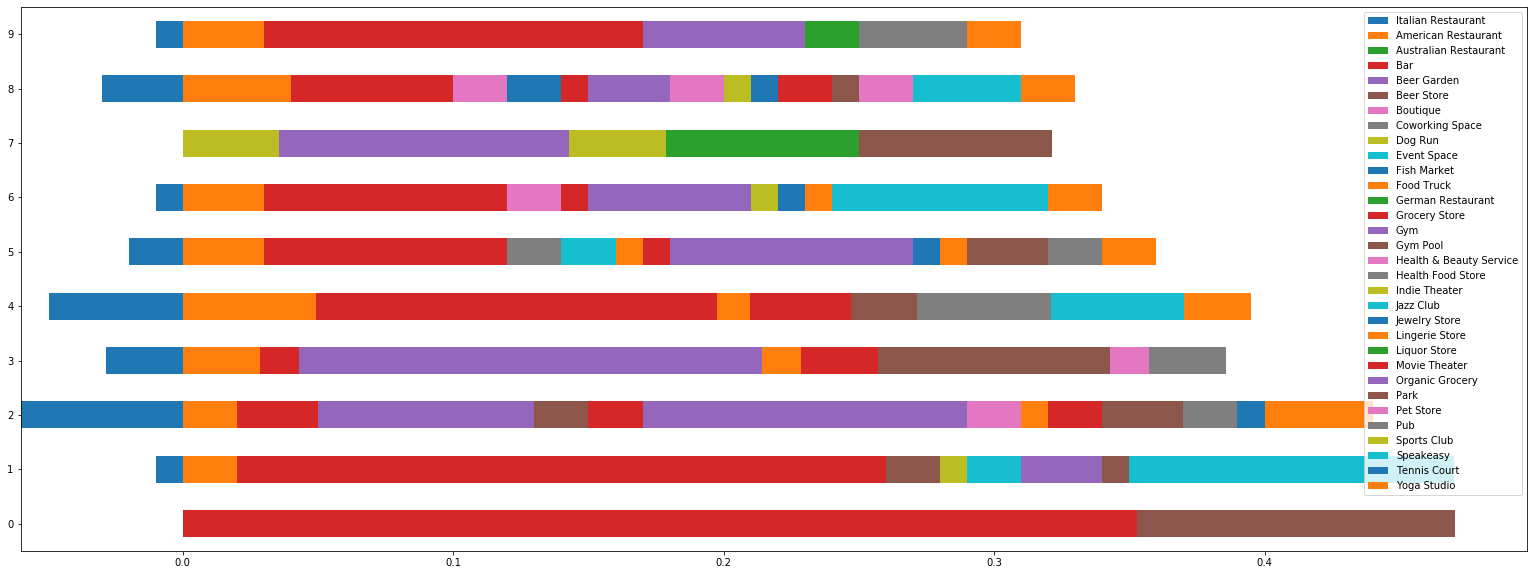

In [200]:
relevant_data = relevant_data.drop(["Neighborhood Score"], axis=1)


visualization = relevant_data[:10].plot.barh(stacked=True, figsize=(27, 10))
visualization

If we take this contribution of the top 10 results into account we can see, that the number of values is not optimally balanced and not all factors came into account.
We can see a very balanced an still a good score (3rd best) in Sutton Place (row 2).

Sutton Palace belongs to cluster 2, the neighborhood shows similarities beyond the factors I chose for the weighted score:

In [201]:
for row in cluster2["Neighborhood"]:
    print(row)

Upper East Side
Lenox Hill
Lincoln Square
Midtown
Chelsea
Greenwich Village
Little Italy
Soho
Noho
Sutton Place
Flatiron


That means I'll not only keep my eyes open in Sutton Palace, I will also use all this information and I hope it will support me.